 Model Performance Report 
              precision    recall  f1-score   support

           0       0.51      0.52      0.51       493
           1       0.52      0.51      0.52       507

    accuracy                           0.52      1000
   macro avg       0.52      0.52      0.52      1000
weighted avg       0.52      0.52      0.52      1000



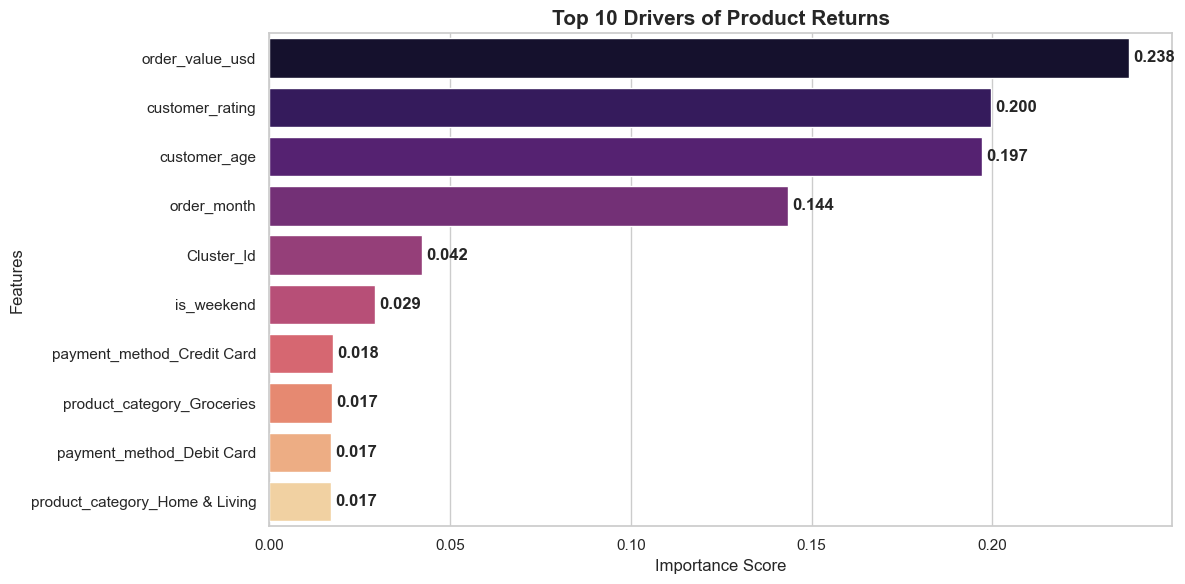


Top 5 Important Features:
order_value_usd    0.237948
customer_rating    0.199708
customer_age       0.197234
order_month        0.143543
Cluster_Id         0.042241
dtype: float64


In [42]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Final
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.container import BarContainer


df = pd.read_pickle('ecommerce_data_cleaned.pkl')

# RFM 
Snapshot_date: Final = df['order_date'].max() + dt.timedelta(days=1)

rfm: pd.DataFrame = df.assign(
    Recency = (Snapshot_date - df['order_date']).dt.days,
    Frequency = 1, # 假設每列為單一訂單
    Monetary = df['order_value_usd']
)[['Recency', 'Frequency', 'Monetary', 'customer_age', 'customer_rating']]

# Clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# K-Means
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
rfm['Cluster_Id'] = kmeans.fit_predict(rfm_scaled)

# Feature Engineering
ml_df = df.merge(rfm[['Cluster_Id']], left_index=True, right_index=True)

ml_df['order_month'] = ml_df['order_date'].dt.month
ml_df['is_weekend'] = ml_df['order_date'].dt.dayofweek.isin([5, 6]).astype(int)

# define cluster
features = [
    'order_value_usd', 'customer_age', 'customer_rating', 
    'Cluster_Id', 'order_month', 'is_weekend', 
    'product_category', 'payment_method'
]

X = ml_df[features]
y = ml_df['returned_status']

# One-Hot Encoding
X = pd.get_dummies(X, columns=['product_category', 'payment_method'], drop_first=True)

# Machine Learning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)

print(" Model Performance Report ")
print(classification_report(y_test, y_pred))

# Feature Importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.set_theme(style='whitegrid')
ax = sns.barplot(x=importances.head(10).values, y=importances.head(10).index, palette='magma', hue=importances.head(10).index, legend=False)

for container in ax.containers:
    if isinstance(container, BarContainer):
        ax.bar_label(container, fmt='%.3f', padding=3, fontweight='bold')

plt.title('Top 10 Drivers of Product Returns', fontsize=15, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("\nTop 5 Important Features:")
print(importances.head(5))

In [43]:
import joblib

joblib.dump(model, 'return_prediction_rf_model.pkl')
print(" Model saved as return_prediction_rf_model.pkl")

# future used
# loaded_model = joblib.load('return_prediction_rf_model.pkl')

 Model saved as return_prediction_rf_model.pkl
